In [1]:
import numpy as np
import random
import os 
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
import torch.nn.functional as F
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp import autocast

from torchsummary import summary
from sklearn.metrics import r2_score

from ray import tune

import json
import itertools
from itertools import groupby
import gzip 
from io import BytesIO
from time import time 
import argparse
import matplotlib.pyplot as plt

import pyBigWig
from scipy.sparse import csc_matrix
import math 

from modules import * 
from model import *


In [2]:
param_vals = { 
"mode": 'regression',
"optimizer" : 'Adam', 
"init_lr": 0.001, 
"optimizer_momentum": 0.9, 
"weight_decay": 1e-3, 
"loss": "poisson", 
"num_targets": [23, 14],
"lambda_param": 0.001, 
"ltype":1,
"clip": 2.,
"seq_len": 128 * 128 * 8,
"target_window": 128 * 8 ,
"batch_size": 4,
"cut": 0.8,
"num_workers": 8,
"num_epochs": 1
}


In [3]:
targets_memmap_data_dir = '/data/users/goodarzilab/darya/work/Datasets/basenji_tutorial_targets_memmaps'
targets_memmap_data_dir_cl = '/data/users/goodarzilab/darya/work/Datasets/hg38_targets_memmaps_CL.ATAC'
targets_memmap_data_dir_pdx = '/data/users/goodarzilab/darya/work/Datasets/hg38_targets_memmaps_PDX.ATAC'
# memmap_data_contigs_dir = '/data/users/goodarzilab/darya/work/Datasets/hg19_memmaps'
memmap_data_contigs_dir = '/data/users/goodarzilab/darya/work/Datasets/hg38_memmaps'

# memmap_data_contigs_dir = os.path.join(os.getcwd(), 'hg_19_mmaps_upd')
# memmap_data_contigs_dir = '/data/users/goodarzilab/darya/work/Datasets/hg19_memmap_data_contigs'



In [4]:
os.listdir(memmap_data_contigs_dir)

['chr21_contigs_sequence.dta',
 'chr5_contigs_sequence.dta',
 'chr19_contigs_sequence.dta',
 'chr12_contigs_sequence.dta',
 'chr14_contigs_sequence.dta',
 'chr8_contigs_sequence.dta',
 'chr3_contigs_sequence.dta',
 'chr20_contigs_sequence.dta',
 'chr4_contigs_sequence.dta',
 'chr13_contigs_sequence.dta',
 'chr18_contigs_sequence.dta',
 'chr15_contigs_sequence.dta',
 'chr2_contigs_sequence.dta',
 'chr9_contigs_sequence.dta',
 'chr10_contigs_sequence.dta',
 'chr7_contigs_sequence.dta',
 'chr1_contigs_sequence.dta',
 'chr16_contigs_sequence.dta',
 'chrY_contigs_sequence.dta',
 'jupyter.log',
 'chr11_contigs_sequence.dta',
 'chr6_contigs_sequence.dta',
 'chr22_contigs_sequence.dta',
 'chrX_contigs_sequence.dta',
 'chr17_contigs_sequence.dta']

In [5]:
num_targets_total = np.sum(param_vals.get("num_targets"))

In [6]:
model = BasenjiModel(num_targets=num_targets_total) 
model.compile(device='cuda')


In [7]:
input_files_dir = memmap_data_contigs_dir
# target_files_dir = [targets_memmap_data_dir]
target_files_dir = [targets_memmap_data_dir_cl, targets_memmap_data_dir_pdx]


In [8]:
np.sum([2, 3])

5

In [9]:
max([2])

2

In [10]:
355246464 / 223971744 

1.5861217922203614

In [11]:
memmap_data_contigs_dir

'/data/users/goodarzilab/darya/work/Datasets/hg38_memmaps'

In [12]:
basenji_tutorial_targets_memmaps_dir = os.path.join('/data/users/goodarzilab/darya/work/Datasets', 'basenji_tutorial_targets_memmaps')
chr1_mmap = [file for file in os.listdir(memmap_data_contigs_dir) if file.split('_')[0] == 'chr1']
chr1_inp = np.memmap(os.path.join(memmap_data_contigs_dir, chr1_mmap[0]), dtype='float32',  mode = 'r+')
chr1_tg = np.memmap(os.path.join(basenji_tutorial_targets_memmaps_dir, 'chr1_targets_contigs_sequence.dta'), dtype='float32',  mode = 'r+') 

In [13]:
target_window = 128 * 8 
idx = 0
chrom_len = chr1_inp.shape[0]

In [14]:
arr = np.arange(idx*target_window, (idx+1) * target_window)
tgt_lst = np.arange(0, chrom_len*3, chrom_len)
ids = np.array([np.split(arr, target_window/128) + tgt for tgt in tgt_lst])

In [15]:
val = torch.mean(torch.tensor(np.nan_to_num(np.take(chr1_tg, ids))), dim=-1)

In [16]:
val.shape

torch.Size([3, 8])

init dsets
began training
4440 1164
Train Epoch: 0 [0/4440 (0%)]	Loss: 106110.179688	R: 0.000013	R2: -512.767334
945.5101928710938 105763.0078125


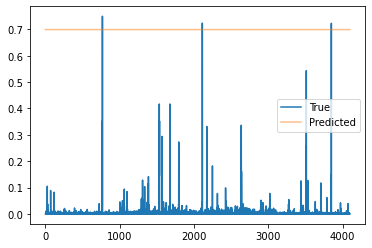

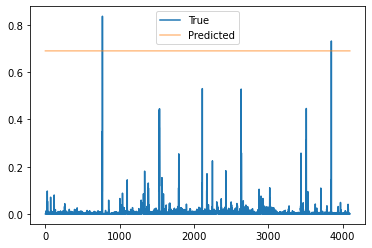

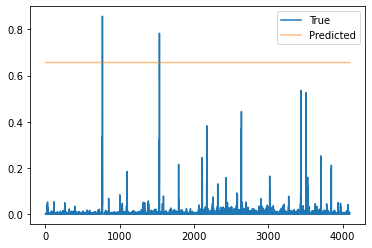

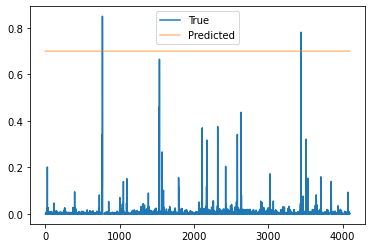

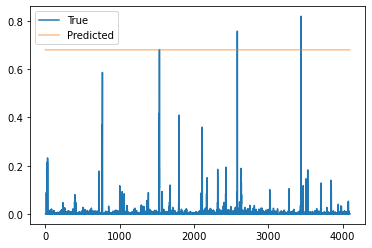

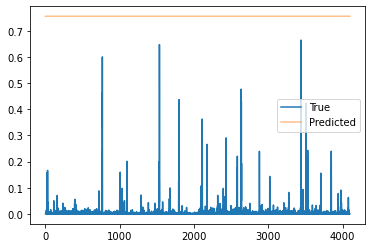

Train Epoch: 0 [10/4440 (0%)]	Loss: 94152.765625	R: 0.006650	R2: -524.633057
Train Epoch: 0 [20/4440 (0%)]	Loss: 75553.195312	R: 0.019590	R2: -316.420715
Train Epoch: 0 [30/4440 (0%)]	Loss: 59614.605469	R: 0.011857	R2: -193.072296
Train Epoch: 0 [40/4440 (0%)]	Loss: 46145.128906	R: 0.010619	R2: -114.724892


KeyboardInterrupt: 

In [17]:
trainer = Trainer(param_vals, model, input_files_dir, target_files_dir)
trainer.train(debug=False)

init dsets
began training
4030 1379
Train Epoch: 0 [0/4030 (0%)]	Loss: 8267.305664	R: 0.000000	R2: -470.362061
67.94819641113281 8233.392578125


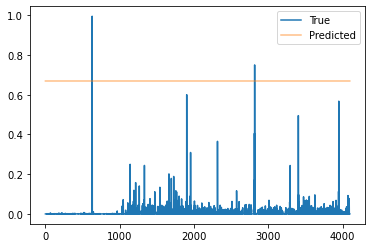

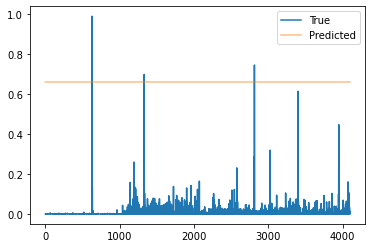

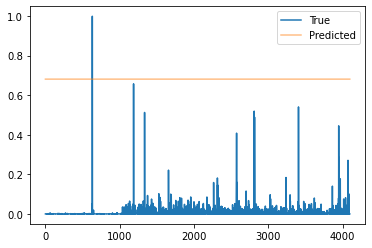

Train Epoch: 0 [10/4030 (0%)]	Loss: 7471.920410	R: 0.005515	R2: -458.565491
Train Epoch: 0 [20/4030 (0%)]	Loss: 6133.388184	R: -0.005711	R2: -296.639221
Train Epoch: 0 [30/4030 (0%)]	Loss: 5029.142090	R: -0.002606	R2: -195.784103
Train Epoch: 0 [40/4030 (0%)]	Loss: 4012.136963	R: -0.005386	R2: -120.931396
Train Epoch: 0 [50/4030 (1%)]	Loss: 3207.433350	R: 0.002627	R2: -75.293549
Train Epoch: 0 [60/4030 (1%)]	Loss: 2528.728760	R: 0.001149	R2: -45.081810
Train Epoch: 0 [70/4030 (1%)]	Loss: 1985.356445	R: -0.007014	R2: -24.625759
Train Epoch: 0 [80/4030 (1%)]	Loss: 1470.124756	R: 0.016475	R2: -12.169607
Train Epoch: 0 [90/4030 (2%)]	Loss: 1066.643799	R: -0.014796	R2: -5.417539
Train Epoch: 0 [100/4030 (2%)]	Loss: 880.727661	R: -0.005962	R2: -2.054799
Train Epoch: 0 [110/4030 (2%)]	Loss: 595.550049	R: 0.025938	R2: -0.915231
Train Epoch: 0 [120/4030 (2%)]	Loss: 603.176819	R: 0.015291	R2: -0.327910
Train Epoch: 0 [130/4030 (3%)]	Loss: 577.654114	R: 0.025164	R2: -0.119199
Train Epoch: 0 [140/

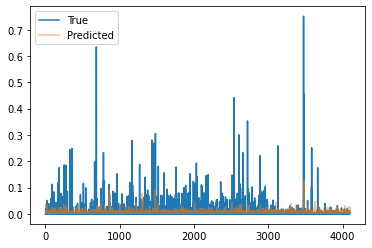

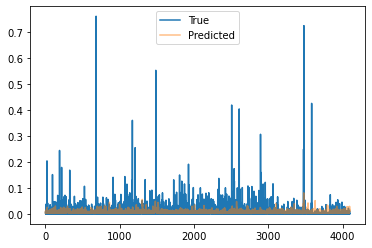

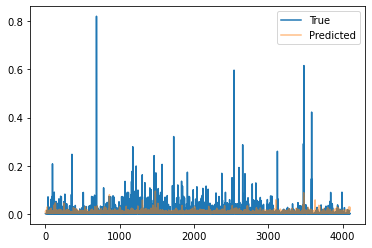

Train Epoch: 0 [310/4030 (7%)]	Loss: 549.647766	R: 0.134764	R2: 0.011309
Train Epoch: 0 [320/4030 (7%)]	Loss: 497.497650	R: 0.053583	R2: -0.016395
Train Epoch: 0 [330/4030 (8%)]	Loss: 474.985321	R: 0.129301	R2: -0.003293
Train Epoch: 0 [340/4030 (8%)]	Loss: 446.815033	R: 0.193447	R2: 0.032540
Train Epoch: 0 [350/4030 (8%)]	Loss: 513.342957	R: 0.107464	R2: 0.002326
Train Epoch: 0 [360/4030 (8%)]	Loss: 447.245636	R: 0.119786	R2: 0.001998
Train Epoch: 0 [370/4030 (9%)]	Loss: 504.998352	R: 0.107275	R2: 0.003032
Train Epoch: 0 [380/4030 (9%)]	Loss: 571.657898	R: 0.123733	R2: 0.009360
Train Epoch: 0 [390/4030 (9%)]	Loss: 516.483032	R: 0.185147	R2: 0.027715
Train Epoch: 0 [400/4030 (9%)]	Loss: 572.369019	R: 0.163410	R2: 0.013358
Train Epoch: 0 [410/4030 (10%)]	Loss: 499.982513	R: 0.147861	R2: 0.005741
Train Epoch: 0 [420/4030 (10%)]	Loss: 549.007874	R: 0.169053	R2: 0.023849
Train Epoch: 0 [430/4030 (10%)]	Loss: 570.602539	R: 0.151351	R2: 0.013059
Train Epoch: 0 [440/4030 (10%)]	Loss: 519.6415

KeyboardInterrupt: 

In [18]:
trainer = Trainer(param_vals, model, input_files_dir, target_files_dir)
trainer.train(debug=False)

init dsets
began training
4051 1358
Train Epoch: 0 [0/4051 (0%)]	Loss: 8421.617188	R: 0.000000	R2: -493.445404
72.68113708496094 8387.9306640625


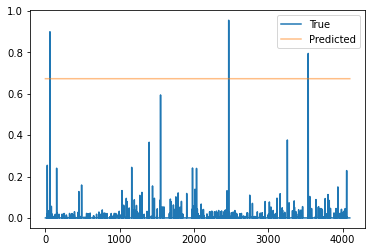

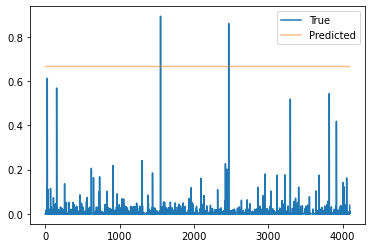

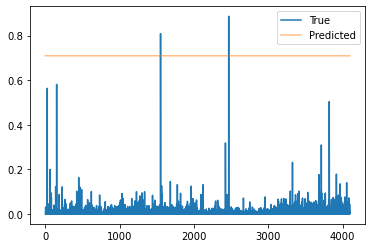

Train Epoch: 0 [10/4051 (0%)]	Loss: 8664.324219	R: 0.007422	R2: -653.891052
Train Epoch: 0 [20/4051 (0%)]	Loss: 7118.376465	R: -0.000611	R2: -417.783691
Train Epoch: 0 [30/4051 (0%)]	Loss: 5827.157227	R: -0.003374	R2: -275.290070


KeyboardInterrupt: 

In [10]:
trainer = Trainer(param_vals, model, input_files_dir, target_files_dir)
trainer.train(debug=False)